Step 1: Import all necessary libraries and establish connection to the SQL database (score.db)

In [204]:
# Import necessary libraries
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Set path to SQL database
db_path = "../data/score.db"

# Create connection to SQL database
conn = sqlite3.connect(db_path)

# Set pandas options for better readability
pd.set_option('display.max_columns', None) # Display all columns in DataFrames
pd.set_option('display.max_rows', 100)     # Limit number of rows displayed

# Setup matplotlib and seaborn for inline visualization
%matplotlib inline
sns.set(style="whitegrid")

Explore structure of database by listing all available tables before any further actions

In [205]:
# Query to list all tables in the database
query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql(query, conn)

# Display list of tables
tables

,name
0,score


Since there is only 'score' table in the database, the first few rows can be previewed to understand its structure

In [206]:
# Preview first few rows of 'score' table
query = "SELECT * FROM score LIMIT 10;"
df_score = pd.read_sql(query, conn)

# Display first 10 rows of the table
df_score.head()

,index,number_of_siblings,direct_admission,CCA,learning_style,student_id,gender,tuition,final_test,n_male,n_female,age,hours_per_week,attendance_rate,sleep_time,wake_time,mode_of_transport,bag_color
0,0,0,Yes,Sports,Visual,ACN2BE,Female,No,69.0,14.0,2.0,16.0,10.0,91.0,22:00,6:00,private transport,yellow
1,1,2,No,Sports,Auditory,FGXIIZ,Female,No,47.0,4.0,19.0,16.0,7.0,94.0,22:30,6:30,private transport,green
2,2,0,Yes,None,Visual,B9AI9F,Male,No,85.0,14.0,2.0,15.0,8.0,92.0,22:30,6:30,private transport,white
3,3,1,No,Clubs,Auditory,FEVM1T,Female,Yes,64.0,2.0,20.0,15.0,18.0,NaN,21:00,5:00,public transport,yellow
4,4,0,No,Sports,Auditory,AXZN2E,Male,No,66.0,24.0,3.0,16.0,7.0,95.0,21:30,5:30,public transport,yellow


The schema of the selected table is retrieved to understand the columns and their data types

In [207]:
# Get schema of 'score' table
query = "PRAGMA table_info(score);"
schema = pd.read_sql(query, conn)

# Display schema information
schema

,cid,name,type,notnull,dflt_value,pk
0,0,index,INTEGER,0,None,0
1,1,number_of_siblings,INTEGER,0,None,0
2,2,direct_admission,TEXT,0,None,0
3,3,CCA,TEXT,0,None,0
4,4,learning_style,TEXT,0,None,0
5,5,student_id,TEXT,0,None,0
6,6,gender,TEXT,0,None,0
7,7,tuition,TEXT,0,None,0
8,8,final_test,REAL,0,None,0
9,9,n_male,REAL,0,None,0


Placeholder

Step 2: Perform Exploratory Data Analysis (EDA) on 'score' table

Firstly, check the number of rows in 'score' table to get a sense of the size of the data

In [208]:
# Get row_count of 'score' table
row_count_query = "SELECT COUNT(*) AS count FROM score;"
row_count = pd.read_sql_query(row_count_query, conn)

# Display number of rows in 'score' table
row_count

,count
0,15900


Next, load all the data into a DataFrame for actual data analysis

In [209]:
# Get all data from 'score' table
score_data_query = "SELECT * FROM score;"
score_data = pd.read_sql_query(score_data_query, conn)

There are some columns in 'score' table that are irrelevant in predicting the students' results <br>
These columns will be dropped from the DataFrame:
- index
- number_of_siblings
- student_id
- gender
- n_male
- n_female
- age
- bag_color

In [210]:
irrelevant_col_list = ["index", "number_of_siblings", "student_id", "gender", "n_male", "n_female", "age", "bag_color"]

drop_col_score_data = score_data.drop(columns = irrelevant_col_list)

Then clean-up the data of missing cell info <br>
Example: If a cell in a row has missing value, then the row should be dropped

In [211]:
# Check the number of rows that have missing data
missing_data = drop_col_score_data.isnull().sum()

# Display number of affected rows
print("Missing values in each column: ")
print(missing_data[missing_data > 0])

Missing values in each column: 
final_test         495
attendance_rate    778
dtype: int64


In [212]:
# Drop rows if there are any missing values
cleaned_score_data = drop_col_score_data.dropna()

# Verify if all missing values are dropped
print("Missing values after dropping rows: ")
print(cleaned_score_data.isnull().sum())

Missing values after dropping rows: 
direct_admission     0
CCA                  0
learning_style       0
tuition              0
final_test           0
hours_per_week       0
attendance_rate      0
sleep_time           0
wake_time            0
mode_of_transport    0
dtype: int64


The 'score' DataFrame is now free from empty cells <br>
However, there are non-numeric values in the table which cannot be used for correlation <br>
So they should be converted into a numeric representation

In [213]:
# Create empty dict to add in converted value labels for plotting use
convert_label_dict = {}

Starting with direct_admission column:
- 0 - No
- 1 - Yes

Take into account different format of the same pattern (uppercases/lowercases)

In [214]:
# Convert 'No' -> 0 and 'Yes' -> 1 in direct_admission column
cleaned_score_data["direct_admission"] = cleaned_score_data["direct_admission"].str.lower().replace({"no": 0, "yes": 1})

# Check if anything is missed from direct_admission column by checking for unique values
cleaned_score_data["direct_admission"].unique()

# Add conversion to dict
convert_label_dict["direct_admission"] = ['0 - No', '1 - Yes']

C:\Users\waele\AppData\Local\Temp\ipykernel_20648\3252133593.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cleaned_score_data["direct_admission"] = cleaned_score_data["direct_admission"].str.lower().replace({"no": 0, "yes": 1})
C:\Users\waele\AppData\Local\Temp\ipykernel_20648\3252133593.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_score_data["direct_admission"] = cleaned_score_data["direct_admission"].str.lower().replace({"no": 0, "yes": 1})


Next is CCA column:
- 0 - Sports
- 1 - Arts
- 2 - Clubs
- 3 - None

Take into account different format of the same pattern (uppercases/lowercases)

In [215]:
# Convert 'Sports' -> 0, 'Arts' -> 1, "Clubs" -> 2 and "None" -> 3 in CCA column
cleaned_score_data["CCA"] = cleaned_score_data["CCA"].str.lower().replace({"sports": 0, "arts": 1, "clubs": 2, "none": 3})

# Check if anything is missed from CCA column by checking for unique values
cleaned_score_data["CCA"].unique()

# Add conversion to dict
convert_label_dict["CCA"] = ['0 - Sports', '1 - Arts', '2 - Clubs', '3 - None']

C:\Users\waele\AppData\Local\Temp\ipykernel_20648\2189449220.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cleaned_score_data["CCA"] = cleaned_score_data["CCA"].str.lower().replace({"sports": 0, "arts": 1, "clubs": 2, "none": 3})
C:\Users\waele\AppData\Local\Temp\ipykernel_20648\2189449220.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_score_data["CCA"] = cleaned_score_data["CCA"].str.lower().replace({"sports": 0, "arts": 1, "clubs": 2, "none": 3})


Replace learning_style column with following format:
- 0 - Visual
- 1 - Auditory

In [216]:
# Convert 'Visual' -> 0 and 'Auditory' -> 1 in learning_style column
cleaned_score_data["learning_style"] = cleaned_score_data["learning_style"].str.lower().replace({"visual": 0, "auditory": 1})

# Check if anything is missed from learning_style column by checking for unique values
cleaned_score_data["learning_style"].unique()

# Add conversion to dict
convert_label_dict["learning_style"] = ['0 - Visual', '1 - Auditory']

C:\Users\waele\AppData\Local\Temp\ipykernel_20648\2538200215.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cleaned_score_data["learning_style"] = cleaned_score_data["learning_style"].str.lower().replace({"visual": 0, "auditory": 1})
C:\Users\waele\AppData\Local\Temp\ipykernel_20648\2538200215.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_score_data["learning_style"] = cleaned_score_data["learning_style"].str.lower().replace({"visual": 0, "auditory": 1})


Replace tuition column with following format:
- 0 - N/No
- 1 - Y/Yes

In [217]:
# Convert 'No'/'N' -> 0 and 'Yes'/'Y' -> 1 in tuition column
cleaned_score_data["tuition"] = cleaned_score_data["tuition"].str.lower().replace({"no": 0, "yes": 1, "n": 0, "y": 1})

# Check if anything is missed from tuition column by checking for unique values
cleaned_score_data["tuition"].unique()

# Add conversion to dict
convert_label_dict["tuition"] = ['0 - No/N', '1 - Yes/Y']

C:\Users\waele\AppData\Local\Temp\ipykernel_20648\1277062835.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cleaned_score_data["tuition"] = cleaned_score_data["tuition"].str.lower().replace({"no": 0, "yes": 1, "n": 0, "y": 1})
C:\Users\waele\AppData\Local\Temp\ipykernel_20648\1277062835.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_score_data["tuition"] = cleaned_score_data["tuition"].str.lower().replace({"no": 0, "yes": 1, "n": 0, "y": 1})


Replace mode_of_transport column with following format:
- 0 - Walk
- 1 - Public Transport
- 2 - Private Transport

In [218]:
# Convert 'Walk' -> 0, 'Public Transport' -> 1 and "Private Transport" -> 2 in mode_of_transport column
cleaned_score_data["mode_of_transport"] = cleaned_score_data["mode_of_transport"].str.lower().replace({"walk": 0, "public transport": 1, "private transport": 2})

# Check if anything is missed from mode_of_transport column by checking for unique values
cleaned_score_data["mode_of_transport"].unique()

# Add conversion to dict
convert_label_dict["mode_of_transport"] = ['0 - Walk', '1 - Public Transport', '2 - Private Transport']

C:\Users\waele\AppData\Local\Temp\ipykernel_20648\207538169.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cleaned_score_data["mode_of_transport"] = cleaned_score_data["mode_of_transport"].str.lower().replace({"walk": 0, "public transport": 1, "private transport": 2})
C:\Users\waele\AppData\Local\Temp\ipykernel_20648\207538169.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_score_data["mode_of_transport"] = cleaned_score_data["mode_of_transport"].str.lower().replace({"walk": 0, "public transport": 1, "

Since sleep_time & wake_time columns are the only ones that are of non int/float values, they will need to be converted to numeric value <br>
These two columns will be used to calculate the number of hours of sleep each student has to try and get a correlation result

In [219]:
# Create function to calculate sleep hours
def cal_sleep_hours(sleep_time, wake_time):
    # Convert sleep_time and wake_time to datetime objects
    sleep_time = datetime.strptime(sleep_time, '%H:%M')
    wake_time = datetime.strptime(wake_time, "%H:%M")

    # If wake_time is earlier than sleep_time, assume wake_time is on the next day
    if wake_time < sleep_time:
        wake_time += pd.Timedelta(days = 1)

    # Calculate difference in hours
    sleep_duration = (wake_time - sleep_time).total_seconds() / 3600 # Convert seconds to hours

    return sleep_duration

# Apply function to calculate sleep hours for each row
cleaned_score_data["sleep_hours"] = cleaned_score_data.apply(lambda row: cal_sleep_hours(row["sleep_time"], row["wake_time"]), axis = 1)

# Drop sleep_time and wake_time columns since they cannot be correlated
time_col_list = ["sleep_time", "wake_time"]
cleaned_score_data = cleaned_score_data.drop(columns = time_col_list)

# Check updated DataFrame
cleaned_score_data

C:\Users\waele\AppData\Local\Temp\ipykernel_20648\3759779212.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_score_data["sleep_hours"] = cleaned_score_data.apply(lambda row: cal_sleep_hours(row["sleep_time"], row["wake_time"]), axis = 1)


,direct_admission,CCA,learning_style,tuition,final_test,hours_per_week,attendance_rate,mode_of_transport,sleep_hours
0,1,0,0,0,69.0,10.0,91.0,2,8.0
1,0,0,1,0,47.0,7.0,94.0,2,8.0
2,1,3,0,0,85.0,8.0,92.0,2,8.0
4,0,0,1,0,66.0,7.0,95.0,1,8.0
5,0,1,0,0,57.0,11.0,96.0,2,8.0
...,...,...,...,...,...,...,...,...,...
15895,0,2,0,0,56.0,9.0,96.0,2,8.0
15896,1,3,1,1,85.0,7.0,91.0,2,8.0
15897,1,0,1,1,76.0,7.0,93.0,0,8.0
15898,0,2,0,1,45.0,3.0,94.0,0,8.0


It can now be used to generate summary statistics to check on the mean, median, 25%, etc

In [220]:
# Get summary statistics from 'score' DataFrame
summary_stats = cleaned_score_data.describe()

# Display summary statistics
summary_stats

,direct_admission,CCA,learning_style,tuition,final_test,hours_per_week,attendance_rate,mode_of_transport,sleep_hours
count,14648.000000,14648.000000,14648.000000,14648.000000,14648.000000,14648.000000,14648.000000,14648.000000,14648.000000
mean,0.292804,1.503072,0.575505,0.565811,67.146300,10.320999,93.265770,1.197774,7.845371
std,0.455065,1.115745,0.494283,0.495667,13.962471,4.464532,7.986489,0.748410,0.605203
min,0.000000,0.000000,0.000000,0.000000,32.000000,0.000000,40.000000,0.000000,4.000000
25%,0.000000,1.000000,0.000000,0.000000,56.000000,7.000000,92.000000,1.000000,8.000000
50%,0.000000,2.000000,1.000000,1.000000,68.000000,9.000000,95.000000,1.000000,8.000000
75%,1.000000,2.000000,1.000000,1.000000,78.000000,14.000000,97.000000,2.000000,8.000000
max,1.000000,3.000000,1.000000,1.000000,100.000000,20.000000,100.000000,2.000000,8.000000


Placeholder

The subsequent parts will analyze the patterns and distributions in 'score' DataFrame

Firstly, plot histograms for each numeric column against final_test to understand their distributions

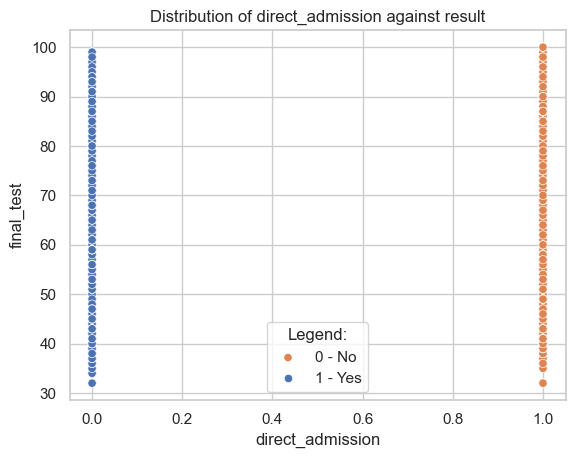

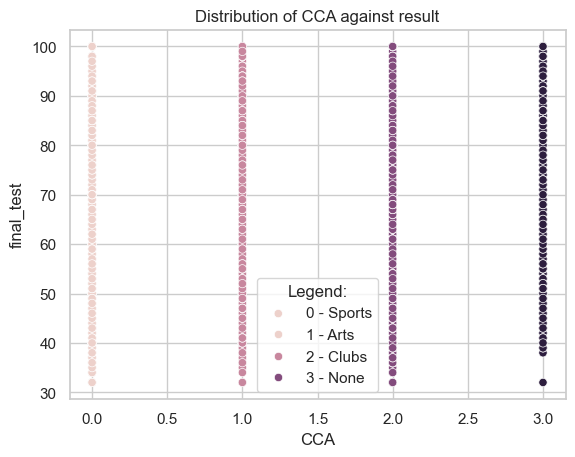

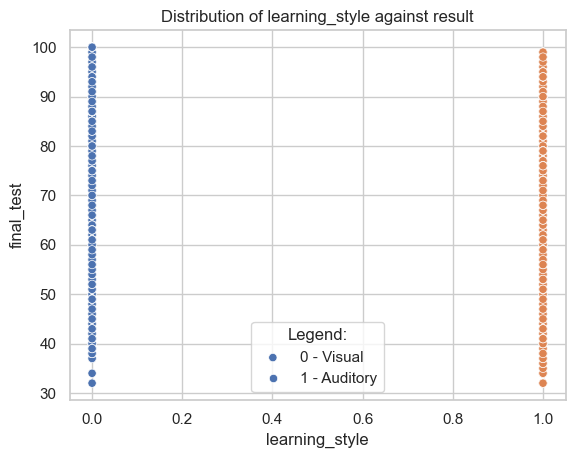

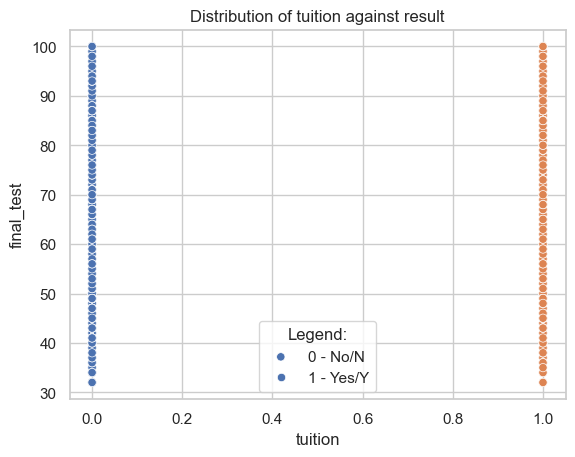

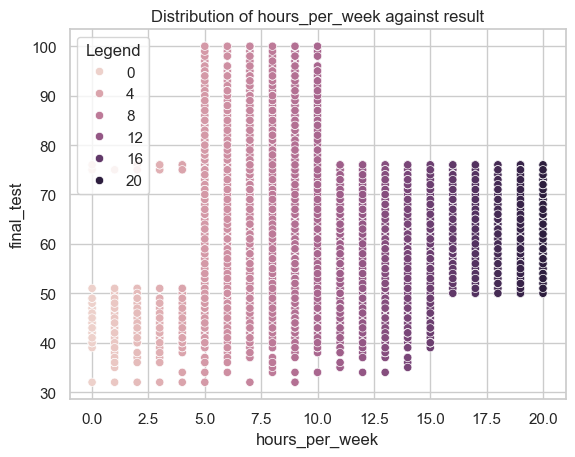

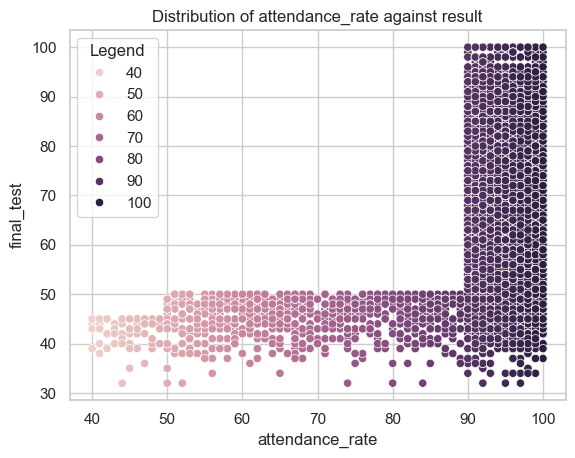

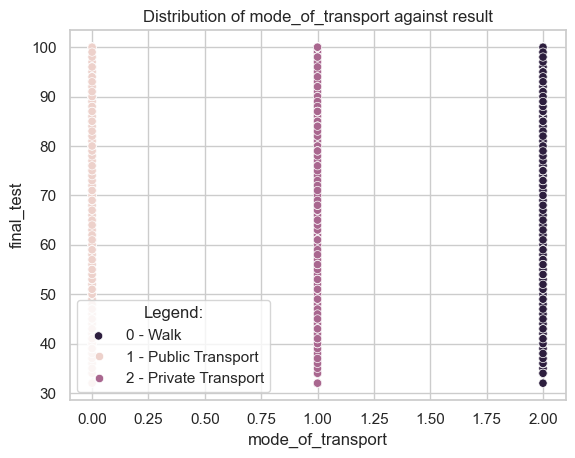

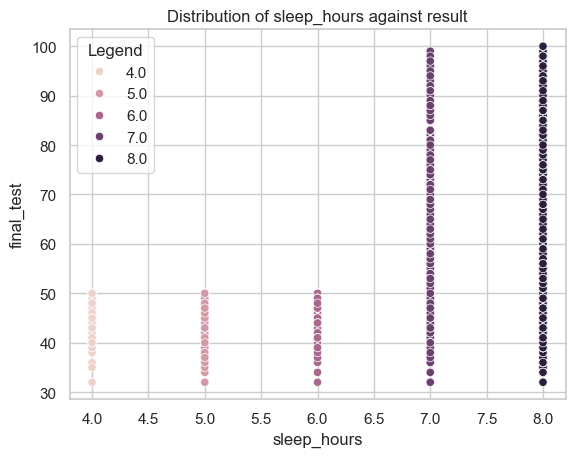

In [ ]:
# Define the result column name
result_col = "final_test"

# Select numeric columns only (excluding the result column)
numeric_cols = cleaned_score_data.select_dtypes(include=['float', 'int']).columns
numeric_cols = [col for col in numeric_cols if col != result_col]

for col in numeric_cols:
    sns.scatterplot(data = cleaned_score_data, x = col, y = result_col, hue = col)
    plt.title(f"Distribution of {col} against result")
    plt.xlabel(col)
    plt.ylabel(result_col)
    if col in convert_label_dict:
        plt.legend(labels = convert_label_dict[col], title = "Legend:", loc = "best")
    else:
        plt.legend(title = "Legend:", loc = "best")
    plt.show()

As direct_admission, CCA, learning_style, tuition and mode_of_transport columns cannot be used to draw any meaningful correlation results, they will be dropped

In [222]:
# Populate list with columns to be dropped
exclude_col_list = ["direct_admission", "CCA", "learning_style", "tuition", "mode_of_transport"]

# Drop columns
fil_score_data = cleaned_score_data.drop(columns = exclude_col_list)

# Check DataFrame
fil_score_data

,final_test,hours_per_week,attendance_rate,sleep_hours
0,69.0,10.0,91.0,8.0
1,47.0,7.0,94.0,8.0
2,85.0,8.0,92.0,8.0
4,66.0,7.0,95.0,8.0
5,57.0,11.0,96.0,8.0
...,...,...,...,...
15895,56.0,9.0,96.0,8.0
15896,85.0,7.0,91.0,8.0
15897,76.0,7.0,93.0,8.0
15898,45.0,3.0,94.0,8.0


Check scatterplot of remaining data to determine correlation again

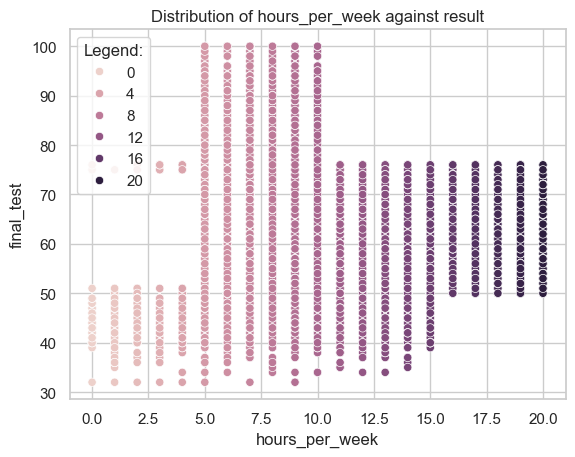

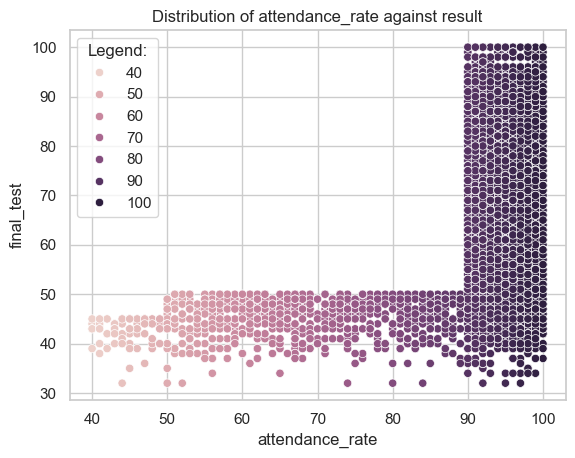

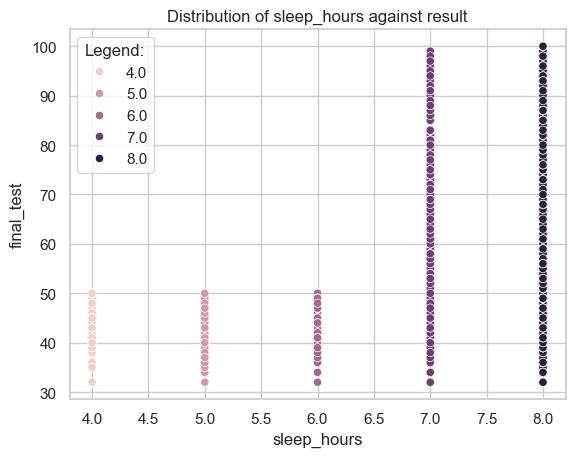

In [225]:
# Select numeric columns only (excluding the result column)
new_numeric_cols = fil_score_data.select_dtypes(include=['float', 'int']).columns
new_numeric_cols = [col for col in new_numeric_cols if col != result_col]

for col in new_numeric_cols:
    sns.scatterplot(data = fil_score_data, x = col, y = result_col, hue = col)
    plt.title(f"Distribution of {col} against result")
    plt.xlabel(col)
    plt.ylabel(result_col)
    if col in convert_label_dict:
        plt.legend(labels = convert_label_dict[col], title = "Legend:", loc = "best")
    else:
        plt.legend(title = "Legend:", loc = "best")
    plt.show()

Perform matrix correlation between different columns

In [ ]:
corr_matrix = fil_score_data.corr()
sns.heatmap(corr_matrix, annot = True, cmap = "coolwarm")
plt.title("Correlation Matrix")
plt.show()